# Vehicle Detection

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

## Load data

In [3]:
cars = []
notcars = []

# Divide up into cars and notcars
images = glob.glob('data/*/*/*.png')

for image in images:
    if 'vehicles' in image:
        cars.append(image)
    elif 'not-cars' in image:
        notcars.append(image)

print ( "Number of images containing cars:", len(cars))
print ( "Number of images not containing cars:", len(notcars))

Number of images containing cars: 8792
Number of images not containing cars: 8968


## Functions to extract features

In [8]:
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),  orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion to YCrCb
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
   
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features


## Define parameters

In [4]:
# Define HOG parameters
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# Spatial size and histogram parameters
spatial_size=(16, 16)
hist_bins=16

## Test and visualization HOG

Analyzing pictures:  ['data/vehicles/KITTI_extracted/2057.png']


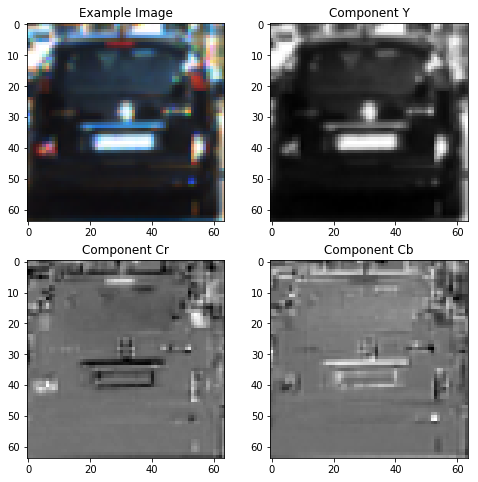

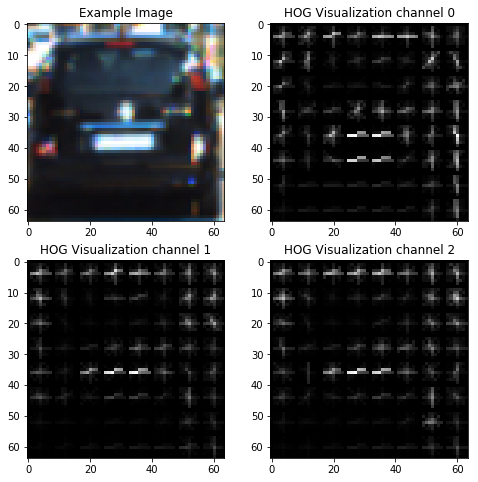

In [9]:
# Reduce the sample size because HOG features are slow to compute
sample_size = 1
sample_cars = cars[0:sample_size]
sample_notcars = notcars[0:sample_size]

print ("Analyzing pictures: ", sample_cars)

# Read in the image
image = mpimg.imread(sample_cars[0])
# Convert in YCrCb
image_YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

# Call our function with vis=True to see an image output
hog_features = []
hog_images = []
for channel in range(image_YCrCb.shape[2]):
    features, hog_image = get_hog_features(image_YCrCb[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
    hog_features.append(features)
    hog_images.append(hog_image)
    
    
# Plot the examples
fig = plt.figure(figsize = (8,8))
plt.subplot(221)
plt.imshow(image)
plt.title('Example Image')
plt.subplot(222)
plt.imshow(image_YCrCb[:,:,0], cmap='gray')
plt.title('Component Y')
plt.subplot(223)
plt.imshow(image_YCrCb[:,:,1], cmap='gray')
plt.title('Component Cr')
plt.subplot(224)
plt.imshow(image_YCrCb[:,:,2], cmap='gray')
plt.title('Component Cb')
    
# Plot the examples
fig = plt.figure(figsize = (8,8))
plt.subplot(221)
plt.imshow(image)
plt.title('Example Image')
plt.subplot(222)
plt.imshow(hog_images[0], cmap='gray')
plt.title('HOG Visualization channel 0')
plt.subplot(223)
plt.imshow(hog_images[1], cmap='gray')
plt.title('HOG Visualization channel 1')
plt.subplot(224)
plt.imshow(hog_images[2], cmap='gray')
plt.title('HOG Visualization channel 2')

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time
import pickle

print ('Extracting car features')
car_features = extract_features(cars, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print ('Extracting not-car features')
notcar_features = extract_features(notcars, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',spatial_size, 'spatial_size' , hist_bins, 'hist_bins')
print('HOG: Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')




Extracting car features
Extracting not-car features
Using: (16, 16) spatial_size 16 hist_bins
HOG: Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
26.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
0.01013 Seconds to predict 10 labels with SVC


hist_bins=32
spatial_size=(32, 32)
Using: 24 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 31968
53.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9794
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.03945 Seconds to predict 10 labels with SVC
------------------------------------------------------------------------
Extracting car features
Extracting not-car features
Using: (16, 16) spatial_size 16 hist_bins
HOG: Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
26.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
0.01013 Seconds to predict 10 labels with SVC

In [15]:
# Save model Classifier
from sklearn.externals import joblib
joblib.dump(svc, 'svc_model.pkl') 

#svc2 = joblib.load('svc_model.pkl') 
#n_predict = 10
#print('My SVC predicts: ', svc2.predict(X_test[0:n_predict]))
#print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    

My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
